In [1]:
!pip install opencv-python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from glob import glob
from PIL import Image
from numpy import asarray

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os  # Import the os module

# Update with the copied path
dirct = "/content/drive/MyDrive/Brain_Tumor_Dataset" #  Update this to the copied path
image_folder_path = os.path.join(dirct, 'Brain Tumor Data', 'Training', 'no_tumor') #  Update this to the copied path



In [9]:
# Corrected path:
augmented_data_path = os.path.join(dirct, 'Brain Tumor Data', 'Augmented_Data', 'Training', 'no_tumor')


In [10]:
no_tumor_frompath= dirct+'/Brain Tumor Data/Training/no_tumor'
no_tumor_topath = dirct+'/Brain Tumor Data/Agumented_Data/Training/no_tumor/'
no_tumor_images=glob(no_tumor_frompath+'/*')
c=0
for path in no_tumor_images:
  img=Image.open(path)
  img=img.resize((224,224))
  img.save(no_tumor_topath+str(c)+'.jpg')
  c+=1
  mirimg=img.transpose(Image.FLIP_LEFT_RIGHT)
  mirimg.save(no_tumor_topath+str(c)+'.jpg')
  c+=1
  rotimg=img.rotate(90,Image.NEAREST, expand = 1)
  rotimg.save(no_tumor_topath+str(c)+'.jpg')
  c+=1
  mirrotimg=rotimg.transpose(Image.FLIP_LEFT_RIGHT)
  mirrotimg.save(no_tumor_topath+str(c)+'.jpg')
  c+=1

In [11]:
import cv2
X=[]
Y=[]

# Define the classes variable
classes = {'no_tumor': 0, 'pituitary_tumor': 1}  # Assign numerical labels to each class

for cls in classes:
  # Corrected path construction
  # Using os.path.join to ensure correct path combination with 'Agumented_Data' and class name
  pth = os.path.join(dirct, 'Agumented_Data', 'Training', cls) #fixed by adding Training
  #pth = dirct + '/Agumented_Data/' + cls

  for j in os.listdir(pth):
    img = cv2.imread(os.path.join(pth, j))   # Use os.path.join here as well
    # img = cv2.resize(img,dsize=(224,224))
    X.append(img)
    Y.append(classes[cls]) # Append the numerical label corresponding to the class

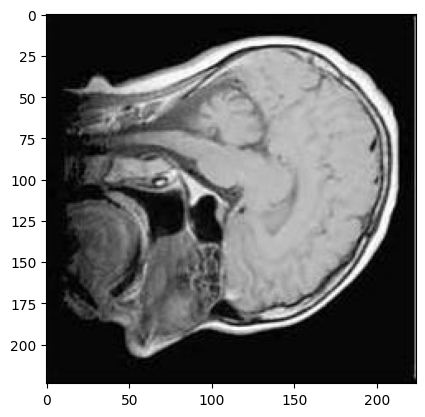

In [12]:
plt.imshow(X[0],cmap='gray')

In [13]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,random_state=10,test_size=0.20)
print ("Shape of an image in x_train: ", x_train[0].shape)
print ("Shape of an image in x_test: ", x_test[0].shape)

Shape of an image in x_train:  (224, 224, 3)
Shape of an image in x_test:  (224, 224, 3)


In [14]:
from sklearn import preprocessing
import tensorflow as tf
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
x_train = np.array(x_train)
y_test = np.array(y_test)
x_test = np.array(x_test)
print("x_train Shape: ", x_train.shape)
print("x_test Shape: ", x_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

x_train Shape:  (3910, 224, 224, 3)
x_test Shape:  (978, 224, 224, 3)
y_train Shape:  (3910, 2)
y_test Shape:  (978, 2)


In [15]:
from keras.applications import vgg16

img_rows,img_cols=224,224

vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows,img_cols,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
for layer in vgg.layers:
  layer.trainable=False


In [17]:
from tensorflow.keras.layers import GlobalAveragePooling2D # Import from correct module

def lw(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)  # Now GlobalAveragePooling2D should work
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)
  return top_model

In [18]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.models import Model

In [19]:
import tempfile

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__


In [20]:
make_keras_picklable()

In [21]:
num_classes=2
FC_Head=lw(vgg,num_classes)
model=Model(inputs=vgg.input,outputs=FC_Head)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [22]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
history=model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test),verbose=1,initial_epoch=0)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - accuracy: 0.8425 - loss: 1.2814 - val_accuracy: 0.9765 - val_loss: 0.0619
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 201ms/step - accuracy: 0.9779 - loss: 0.0622 - val_accuracy: 0.9857 - val_loss: 0.0471
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 250ms/step - accuracy: 0.9862 - loss: 0.0393 - val_accuracy: 0.9642 - val_loss: 0.1009
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 38s 223ms/step - accuracy: 0.9909 - loss: 0.0274 - val_accuracy: 0.9908 - val_loss: 0.0304
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 46s 261ms/step - accuracy: 0.9910 - loss: 0.0201 - val_accuracy: 0.9836 - val_loss: 0.0343


In [24]:
import pickle
filename= 'brain_tumor_model.sav'

In [25]:

pickle.dump(model,open(filename,'wb'))

In [26]:
load_model = pickle.load(open(filename,'rb'))
#load_model.predict(x_test)

In [27]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# Changed filename to end with .weights.h5
model.save_weights("model.weights.h5")

In [28]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
# Corrected filename to match the saved weights file
loaded_model.load_weights("model.weights.h5")

In [29]:
loaded_model.predict(x_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step


array([[9.8115414e-01, 1.8845849e-02],
       [8.4156636e-05, 9.9991584e-01],
       [2.2015634e-01, 7.7984363e-01],
       ...,
       [1.0678662e-03, 9.9893218e-01],
       [7.3671312e-04, 9.9926323e-01],
       [9.3597854e-03, 9.9064028e-01]], dtype=float32)

In [30]:
dec= {0: 'No Tumor', 1:'Positive Tumor'}

In [31]:
import os
# Print the contents of 'Brain_Tumor_Dataset'
print(os.listdir(dirct))

# Print the contents of 'Brain Tumor Data' if it exists
if 'Brain Tumor Data' in os.listdir(dirct):
    print(os.listdir(os.path.join(dirct, 'Brain Tumor Data')))

['Testing', 'Training', 'Agumented_Data']


In [32]:
augmented_data_path = os.path.join(dirct, 'Brain Tumor Data', 'Augmented_Data', 'Training', 'no_tumor')

In [33]:
import cv2
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Directory found: /content/drive/MyDrive/Brain_Tumor_Dataset/Agumented_Data/Training/no_tumor


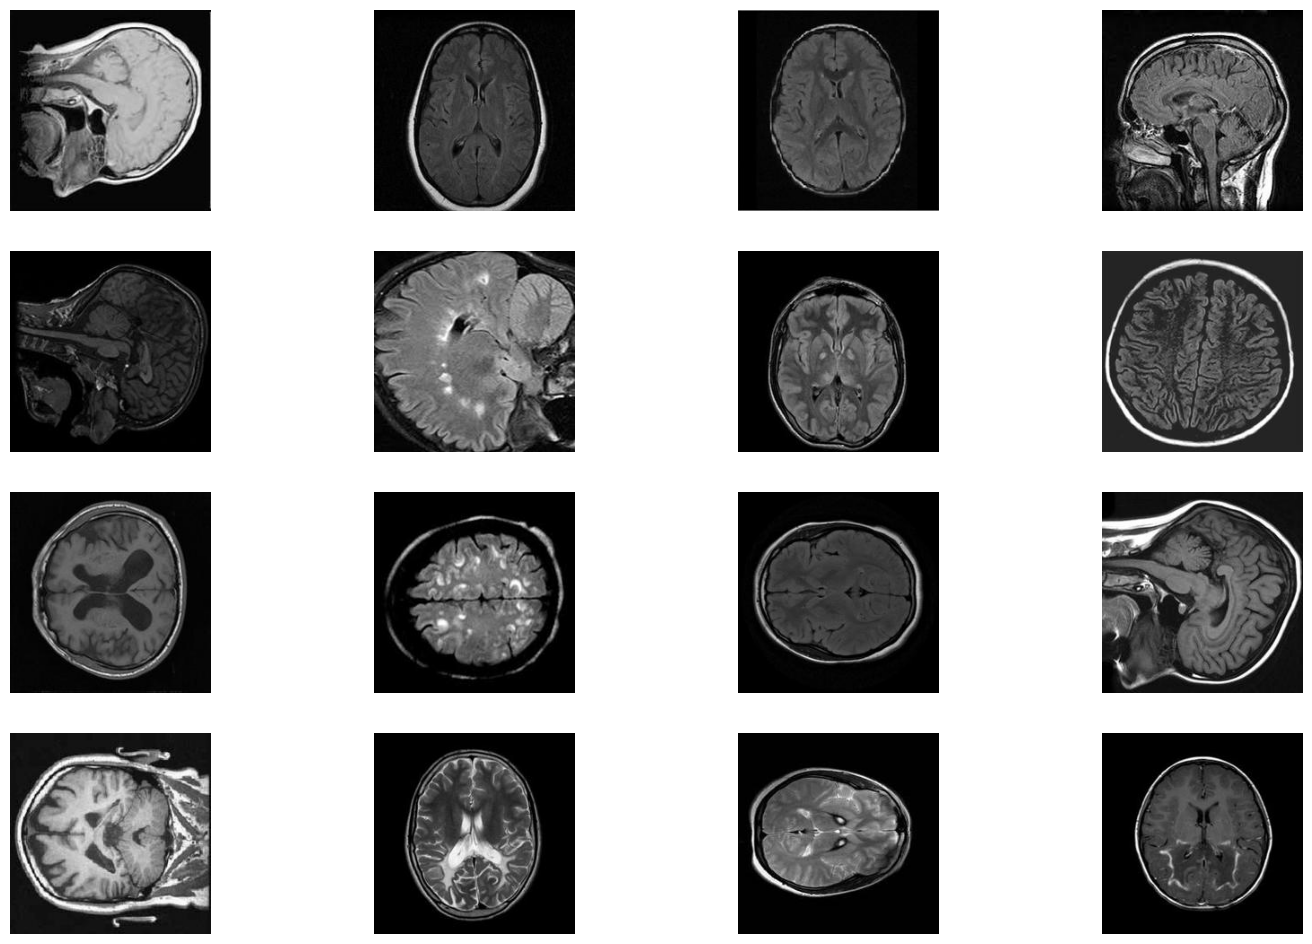

In [35]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Corrected directory path
dirct = "/content/drive/MyDrive/Brain_Tumor_Dataset"
augmented_data_path = os.path.join(dirct, 'Agumented_Data', 'Training', 'no_tumor')

# ✅ Check if the corrected directory exists
if not os.path.exists(augmented_data_path):
    print(f"❌ Error: Augmented data directory not found: {augmented_data_path}")
    print(f"🔍 Available directories: {os.listdir(dirct) if os.path.exists(dirct) else 'Brain_Tumor_Dataset missing!'}")
else:
    print(f"✅ Directory found: {augmented_data_path}")

    plt.figure(figsize=(18, 12))
    c = 1
    predict_img = []

    files = os.listdir(augmented_data_path)

    if not files:
        print("⚠️ Warning: No files found in the directory!")

    for i in files[:16]:
        img_path = os.path.join(augmented_data_path, i)

        if os.path.isfile(img_path):  # Ensure it's a file, not a folder
            img = cv2.imread(img_path)

            if img is None:
                print(f"⚠️ Warning: Unable to read image file {img_path}. Skipping.")
                continue

            img1 = cv2.resize(img, (224, 224))
            predict_img.append(img1)
            plt.subplot(4, 4, c)
            plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
            plt.axis('off')
            c += 1
        else:
            print(f"⚠️ Warning: Skipping non-image file: {img_path}")

    plt.show()
